In [1]:
# loading the language label dictionary
itol_language = {0: 'surprise', 1: 'fear', 2: 'neutral', 3: 'sad', 4: 'happy', 5: 'anger', 6: 'disgust'}

In [2]:
import torch
device = "cpu"#"cuda" if torch.cuda.is_available else "cpu"
device

'cpu'

# 1. Testing with unseen data (language model)

In [3]:
# instance of the model
import torch.nn as nn
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_dim = 768
hidden_dim = 128
output_dim = 7
num_layers = 2

language_model = LSTMClassifier(input_dim, hidden_dim, output_dim, num_layers)
language_model.to(device)

LSTMClassifier(
  (lstm): LSTM(768, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=7, bias=True)
)

In [5]:
!git clone https://github.com/Bhattars1/MSc-Project-Expression-Recognition-

Cloning into 'MSc-Project-Expression-Recognition-'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 103 (delta 37), reused 34 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (103/103), 43.10 MiB | 18.98 MiB/s, done.
Resolving deltas: 100% (37/37), done.


In [6]:
language_model_state_dict = torch.load("MSc-Project-Expression-Recognition-/lstm_model_v3.pth")
language_model.load_state_dict(language_model_state_dict)

<ipython-input-6-82a5c5ec99d7>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  language_model_state_dict = torch.load("MSc-Project-Expression-Recognition-/lstm_model_v3.pth

<All keys matched successfully>

In [7]:
from transformers import BertTokenizer, BertModel

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [8]:
# Preprocessing function
def generate_bert_embeddings(sentence):
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True, max_length=512)
    # Generate embeddings
    with torch.no_grad():
        outputs = model(**inputs)
    # Extract embeddings of the [CLS] token (index 0) for the sentence
    cls_embedding = outputs.last_hidden_state[:, 0, :]
    return cls_embedding.float()

In [9]:
# Prediction function
def predict_text_expression(text):
  with torch.inference_mode():
    embedded_text = generate_bert_embeddings(text).to(device)
    logits = language_model(embedded_text.unsqueeze(0))
    probs = torch.softmax(logits, dim=1).squeeze()
    label = probs.argmax(0)
    return itol_language[label.item()], label.item(), probs

In [10]:
# Checking the predictions from the model
text = ["She was so dirty",
        "This time I won the game, yes",
        "England lost the game this time",
        "WOW, That was totally unexpected"]
for sentence in text:
  prediction, _, probs = predict_text_expression(sentence)
  print(f"{sentence} : {prediction}")
  print(f"Probabilities : {probs}")

She was so dirty : surprise
Probabilities : tensor([0.3471, 0.0286, 0.0237, 0.2714, 0.0046, 0.0985, 0.2260])
This time I won the game, yes : neutral
Probabilities : tensor([0.0157, 0.0520, 0.8367, 0.0199, 0.0532, 0.0134, 0.0092])
England lost the game this time : fear
Probabilities : tensor([0.0688, 0.4975, 0.1202, 0.1243, 0.0834, 0.0537, 0.0522])
WOW, That was totally unexpected : happy
Probabilities : tensor([0.0193, 0.0458, 0.0383, 0.0171, 0.8514, 0.0152, 0.0129])


In [11]:
import random

# Define file paths
dialogues_text_path = 'MSc-Project-Expression-Recognition-/daily_dialouge/dialogues_text.txt'
dialogues_emotion_path = 'MSc-Project-Expression-Recognition-/daily_dialouge/dialogues_emotion.txt'

# Initialize lists to store sentences and their corresponding labels
sentences = []
labels = []

# Read dialogues from the text file
with open(dialogues_text_path, 'r') as text_file:
    raw_dialogues = text_file.readlines()

# Read labels from the emotion file
with open(dialogues_emotion_path, 'r') as label_file:
    raw_labels = label_file.readlines()

# Process each dialogue and corresponding label
for dialogue, label in zip(raw_dialogues, raw_labels):
    # Split the dialogue into individual sentences (utterances)
    utterances = dialogue.strip().split(" __eou__ ")

    # Split the label line into individual emotion labels
    label_list = list(map(int, label.strip().split()))

    # Append each cleaned sentence and its corresponding label to the lists
    for utterance, label in zip(utterances, label_list):
        cleaned_utterance = utterance.replace('__eou__', '').strip()  # Remove '__eou__' and trim spaces
        if cleaned_utterance:  # Only add if the utterance is not empty
            sentences.append(cleaned_utterance)
            labels.append(label)

print(len(sentences), len(labels))


102979 102979


In [12]:
from collections import Counter
Counter(labels)

Counter({2: 353, 0: 85572, 4: 12885, 1: 1022, 6: 1823, 5: 1150, 3: 174})

In [13]:
# Create a dictionary to store sentences by category
category_sentences = {key: [] for key in range(7)}  # Adjust range according to your number of categories

# Populate the dictionary with sentences by category
for sentence, label in zip(sentences, labels):
    if label in category_sentences:
        category_sentences[label].append(sentence)

# Sample 174 items per category
sample_data = []
sample_labels = []

for category, cat_sentences in category_sentences.items():

      sampled_sentences = random.sample(cat_sentences, 174)
      sample_data.extend(sampled_sentences)
      sample_labels.extend([category] * 174)

print(len(sample_data), len(sample_labels))

1218 1218


In [14]:
Counter(sample_labels)

Counter({0: 174, 1: 174, 2: 174, 3: 174, 4: 174, 5: 174, 6: 174})

In [15]:
# getting the text label dictionary from the dataset instruction
text_labels_dict = {
    0: "no emotion",
    1: "anger",
    2: "disgust",
    3: "fear",
    4: "happiness",
    5: "sadness",
    6: "surprise"
}

In [16]:
random_list = [random.randint(0, len(sample_labels) - 1) for _ in range(10)]
for i in random_list:
  print(f"{sample_data[i]}:    {text_labels_dict[sample_labels[i]]}")

What ? What did you buy ?:    surprise
No , no ! Stupid machine , what are you doing ! No !:    anger
Ah , never mind , please .:    no emotion
It's hard for us to believe it . Our instruments have been the best quality for years . Have you any reliable evidence ?:    surprise
Well , it would be a lot easier to finish if you stopped talking to me .:    disgust
I'm not sure if we've got any now . Books of that kind are on this shelf . Well , I'm afraid we've sold out .:    sadness
I swear , I ’ m going to kill you for this .:    disgust
That would be convenient . They might as well ask him to fix the electrical wiring . The circuit breakers keep going out all the time . It ’ s really annoying !:    anger
Not very long from the looks of it !:    disgust
Please fill in the arrival card and sign the register .:    no emotion


In [17]:
# making the label consistent
print(f"test_labels: {text_labels_dict}")
print(f"itol_language_model: {itol_language}")

test_labels: {0: 'no emotion', 1: 'anger', 2: 'disgust', 3: 'fear', 4: 'happiness', 5: 'sadness', 6: 'surprise'}
itol_language_model: {0: 'surprise', 1: 'fear', 2: 'neutral', 3: 'sad', 4: 'happy', 5: 'anger', 6: 'disgust'}


In [18]:
mapping = {
    0: 6,  # 'surprise' -> 'surprise'
    1: 3,  # 'fear' -> 'fear'
    2: 0,  # 'neutral' -> 'no emotion'
    3: 5,  # 'sad' -> 'sadness'
    4: 4,  # 'happy' -> 'happiness'
    5: 1,  # 'anger' -> 'anger'
    6: 2   # 'disgust' -> 'disgust'
}

In [19]:
for i, sentence in enumerate(sample_data[:3]):
  print(f"{sentence}:    {text_labels_dict[sample_labels[i]]}")

Hey , Jim . Wake up !:    no emotion
Sure .:    no emotion
Look ! Someone is celebrating his birthday .:    no emotion


In [20]:
# passing the random texts through preprocessor and model
n = len(sample_labels)
random_index = [random.randint(0, n-1) for _ in range(5)]

for idx in random_index:
  _, prediction, _ = predict_text_expression(sample_data[idx])
  prediction = itol_language[mapping[prediction]]
  print(f"\n{sample_data[idx]}")
  print(f"Prediction: {prediction}")

  org_exp = text_labels_dict[sample_labels[idx]]
  print(f"Original expression: {org_exp}")


That can ’ t be true !
Prediction: sad
Original expression: surprise

Did Bean send these dirty jokes to you , too ? Look !
Prediction: sad
Original expression: anger

It ’ s unfair .
Prediction: disgust
Original expression: sadness

A man stepped on my feet when I was waiting for the taxi .
Prediction: fear
Original expression: disgust

I'm sorry for the misunderstanding .
Prediction: anger
Original expression: sadness


In [21]:
# Initialize the list to hold the mapped predictions
import tqdm
prediction_language_model = []

# Batch size
batch_size = 16

# Prediction:
for i in tqdm.tqdm(range(0, len(sample_data), batch_size)):
    batch = sample_data[i:i+batch_size]
    for sentence in batch:
        _, predict, _ = predict_text_expression(sentence)
        mapped_prediction = mapping[predict]
        prediction_language_model.append(mapped_prediction)

# Display the first 5 predictions
print(prediction_language_model[:5])

100%|██████████| 77/77 [00:43<00:00,  1.79it/s]

[4, 3, 4, 4, 3]


In [22]:
# defining the accuracy function
def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  accuracy=(correct/len(y_true))*100
  return accuracy

In [23]:
accuracy = accuracy_fn(torch.tensor(sample_labels), torch.tensor(prediction_language_model))
print(f"Accuracy: {accuracy:.3f}%")

Accuracy: 16.338%


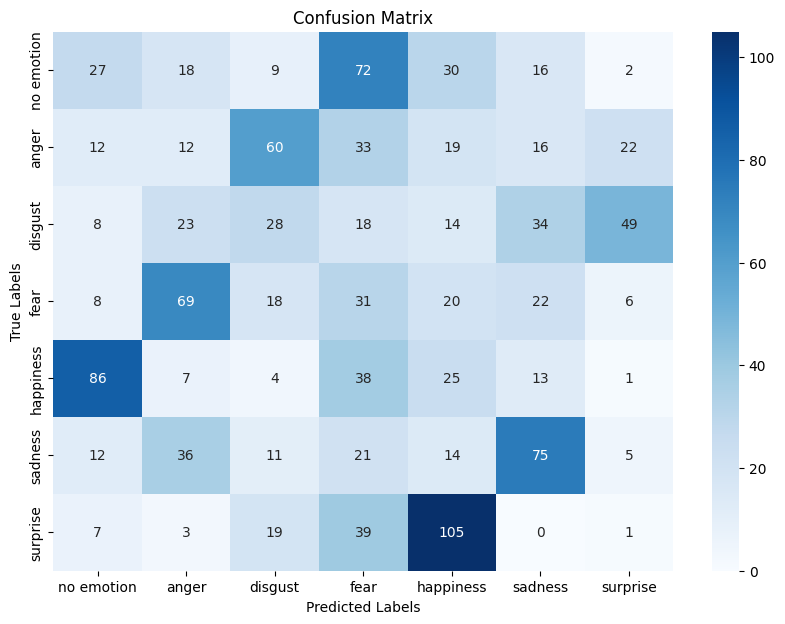

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define class labels based on test_labels
class_labels = [text_labels_dict[i] for i in sorted(text_labels_dict.keys())]

# Compute confusion matrix
conf_matrix = confusion_matrix(sample_labels, prediction_language_model)

# Plot confusion matrix with correct labels
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [87]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Compute precision, recall, and F1 score
precision = precision_score(sample_labels, prediction_language_model, average='weighted')
recall = recall_score(sample_labels, prediction_language_model, average='weighted')
f1 = f1_score(sample_labels, prediction_language_model, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.0370
Recall: 0.1158
F1 Score: 0.0483


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
